<a href="https://colab.research.google.com/github/ChathuraWeerasinghe/ESP32-CSI-Tool/blob/master/Assignment_01_170679D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S8-EN4353 - Radar and Navigation
### Assignment 1 Target and Cloud Detection by Amplitude processing
##### 170679D - D.C.J. Weerasinghe

<font color='Red'>

# How to run the code --->

>>> ### 1) Import the csv file under the load data section.
>>> ### 2) Convert the imported data into a numpy array if the data is on any other form.
>>> ### 3) Go to the input data here topic.
>>> ### 4) Select the imported name of the data.
>>> ### 5) Selct "Run ALL".
>>> ### 6) At each section you'll see necessary plots and results.

</font>

##### Import libraries for necessary .
> * pandas     - load csv files to pands.
> * matplotlib - visualization of raw data.
> * seaborn    - visualization of the data matrix.
> * numpy      - handle matrix functionalities.
> * cv2        - implement floodfill algorythm.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv

#### Load Data

Load data into pandas data frames and convert them into numpy arrays.

> * data1 --> dataset 01 - only clouds. 

> * data2 --> dataset 02 - only objects.

> * data3 --> dataset 03 - both clouds and objects.

In [32]:
df1 = pd.read_csv('raw_data1.csv',sep=';',header=None,squeeze=True)
df2 = pd.read_csv('raw_data2.csv',sep=';',header=None,squeeze=True)
df3 = pd.read_csv('raw_data3.csv',sep=';',header=None,squeeze=True)

data1 = df1.to_numpy()
data2 = df2.to_numpy()
data3 = df3.to_numpy()

Raw data sampled at 1080KHz.

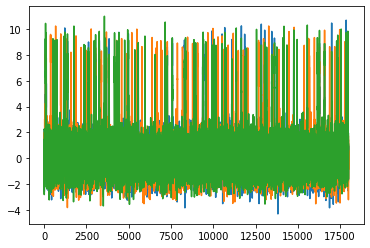

In [33]:
plt.plot(list(range(18000)), data1)
plt.plot(list(range(18000)), data2)
plt.plot(list(range(18000)), data3)
plt.show()

# Parameters

In [34]:
#data given
bins = 30 #no. of range slots
guardBand = 4 #to stop leaking effect from the thresholded value
f_pulseRepetiion = 1800 #pulse repetition frequency
f_samplingData = 1080000 #raw video samplng rate
sigma_n = 1 #standard deviation
rotationSpeed = 12 #radar rotation speed
horizontalBeamWidth = 2 #horozontal beamwidth of the radar

# defined data according to the effect on the output 
k = 1.3 #myltiplication(scaling) for the varience

#common parameters
C = 3e8 #speeed of light

# Input data here -->

In [35]:
#use this to feed imported data on to the algorythm
inputData = data3

# Down Sampling of raw data.

Since one pulse contain 30 bins, required sampling frequency is:

* >sampling frequency = bins * pulse repetition frequency

>>>> $f\_sampling= 30\cdot1800 = 54kHz$

* >theta_rotated = rotationSpeed/60 * sampleLength/f_samplingData * 360
  
>>>>$theta\_rotated = \frac{rotationSpeed \times 360^{\circ}}{60 \times f\_samplingData} = 1.2^{\circ}$

* >echos_theta_beamWidth = (horizontalBeamWidth*f_pulseRepetiion)/(6*rotationSpeed)

>>>>$echos\_theta\_beamWidth = \frac{horizontalBeamWidth \times f\_pulseRepetition}{6 \times rotationSpeed} = 50$

* >no. of echos = radar beamWidth * theta_rotated/horizontalBeamWidth

>>>>$echos = \frac{echos\_theta\_beamWidth \times theta\_rotated^{\circ}}{horizontalBeamWidth} = 30$

Therefore,

>>>>Data matrix size = echos x bins --> 30 x 30

In [36]:
f_sampling = bins*f_pulseRepetiion #sampling freq
sampleLength = len(inputData) #size of the data frame

theta_rotated = rotationSpeed * sampleLength*6/f_samplingData
echos_theta_beamWidth = (horizontalBeamWidth*f_pulseRepetiion)/(6*rotationSpeed)
echos = int((echos_theta_beamWidth * theta_rotated)/horizontalBeamWidth)

sample_matrix=inputData.reshape(echos*bins, sampleLength//(echos*bins)) #matrix beign reshaped into 900x20 for easy calculations

# sampledData = np.transpose(resample(np.transpose(sample_matrix), n_samples=1)).reshape(echos, bins)
sampledData = sample_matrix[:,0].reshape(echos, bins)

print(theta_rotated, echos_theta_beamWidth, echos) 

1.2 50.0 30


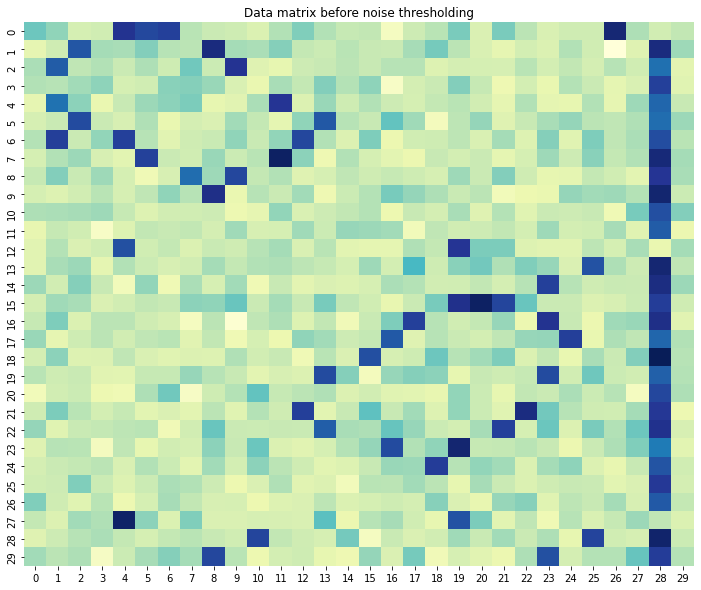

In [37]:
f, ax = plt.subplots(figsize=(12,10))
plt.title("Data matrix before noise thresholding",fontsize = 12)
ax = sns.heatmap(sampledData, square=False,annot=False,cbar=False, cmap="YlGnBu")


# Noise Thresholding

#### Calculate noise average.

To remove the noise present in the data, we have to perfrom a noise thresholding step by calculating noise average using neighboring data point to a certain sample point that we are considering.

As given in the question using a window size of 21 samples and aslo using a guardband of 4 samples we are calculating the noise average value and the dynamic threshold valuefrom the below equations.

* Noise average,

>>>>$(V_n)_{avg} = \frac{\sum(past video) + \sum(future video)}{Number of samples}$ 

Assuming a guardband of j samples,


>>>>$(V_n)_{avg} = \frac{\sum_{i=j+1}^{10} (past video) + \sum_{i=-j-1}^{10} (future video)}{2(m-j)}$

>>

<img src="https://drive.google.com/uc?export=view&id=1l0TDfnyXqEj2A0ykZZGvWT4vlAazc5XL" width="800" height="400">

* Noise threshold, 
>>>>$V_{TH}=(V_n)_{avg}+k\cdot \sigma_n $

* $If\:\: V_{i}>V_{TH}  \: then, $ 

>>> $\:V_{i} =1 $

>> $\:otherwise, $ 

>>> $\:V_{i} = 0$


<font color='yellow'>

Function - thresholding

Arguments:
>* data    - matrix to be thresholded with shape 900x20.
>* sampled     - sampled matrix with shape 30x03.
>* k - scaling value for the given sigma value.
>* sigma_n - standard deviation of the interval which is given as 1.

Output:
>* threshold - calculated thresholds for the each sample point
>* (sampled > threshold)*1 - thresholded matrix with sjape 30*30

</font> 

In [38]:
def thresholding(data, sampled, k, sigma_n):
  
  futureSamples = data[:,guardBand+1:11]
  pastSamples = data[:echos*bins-1,10:data.shape[1]-guardBand]
  pastSamples = np.vstack([futureSamples[0],pastSamples])
  
  guardBandRemoved = np.concatenate((futureSamples,pastSamples),axis=1)
  
  AvgerageNoise = np.mean(guardBandRemoved, axis=1)
  threshold = (AvgerageNoise + k*sigma_n).reshape(echos, bins)
  
  return threshold, (sampled > threshold)*1

In [39]:
threshold, thresholded = thresholding(sample_matrix, sampledData, k, sigma_n)

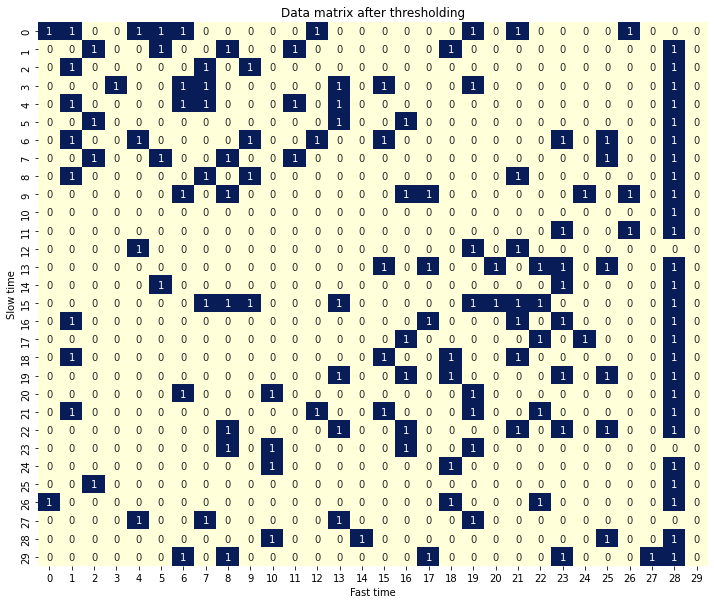

In [40]:
f, ax = plt.subplots(figsize=(12,10))
plt.title("Data matrix after thresholding",fontsize = 12)
ax = sns.heatmap(thresholded, square=False,annot=True,cbar=False,cmap="YlGnBu")
ax=ax.set(xlabel="Fast time",ylabel="Slow time")

# Object Detection

* After initial noise thresholding of the data matrix, we take the column wise summation or summation of values from each range slot.

* If this count > 15 (or no. of columns/2),


* Then there is a target in that range slot.

* Then we have used a column of 0.5s (as specified in the assigment) to signify this identified target.

<font color='yellow'>

Function - object_detection

Arguments:
>* data    - thresholded data matrix with shape 30x30.

Output:
>* objectsDetected - array of numbers indicating range slots where objects detected.
>* data - input matrix with updated range slots for detected objects with shape 30x30.

</font> 

In [41]:
def object_detection(data):
    data = data.astype(np.float)
    sumationThresholdedMatrix = np.sum(data,axis=0)
    objectsDetected = []

    for i in range(sumationThresholdedMatrix.shape[0]):
        if sumationThresholdedMatrix[i] >= (sumationThresholdedMatrix.shape[0]//2):
            objectsDetected.append(i)
    
    for i in objectsDetected:
        data[:,i] = 0.5

    return objectsDetected, data

In [42]:
objectsDetected, thresholded_withObject = object_detection(thresholded)
objectsDetected

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


[28]

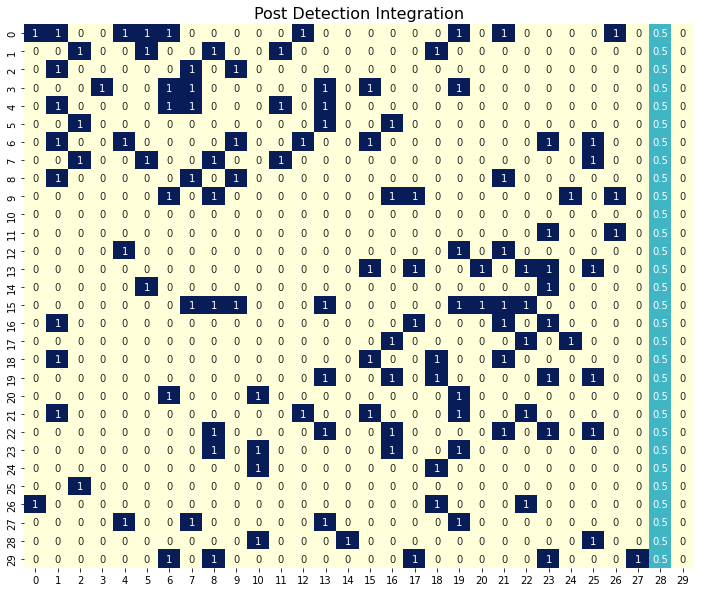

In [43]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Post Detection Integration',fontsize = 16)
ax = sns.heatmap(thresholded_withObject, square=False,annot=True,cbar=False,cmap="YlGnBu")

# Cloud Detection

### Hard thresholding and object removal for cloud detection

In [44]:
#initial noise filtering with the calculated thresold level
filter_01 = np.where(sampledData>threshold,sampledData,0)

#adaptive noise filtering after data visualization
filter_02 = np.where(filter_01>5,filter_01,0)
filter_03 = np.where(filter_02>0,1,0)

# removing detected objects
print(objectsDetected)
filter_03[:,objectsDetected] = 0

[28]


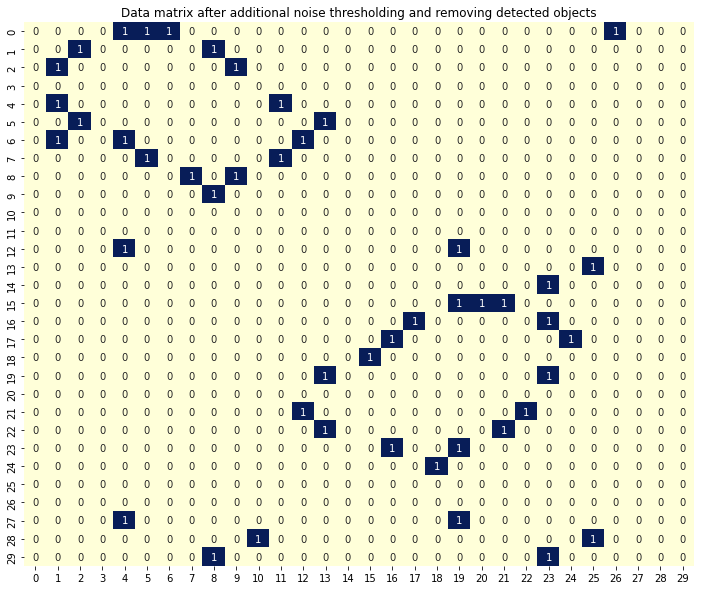

In [45]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Data matrix after additional noise thresholding and removing detected objects',fontsize = 12)
ax = sns.heatmap(filter_03, square=False,annot=True,cbar=False,cmap="YlGnBu")

### Additional noise removal

* A kernel size is selected according to the performance of data.

* This kernal is carried thorugh the input data array with a step size of one on the both axes.

* At each iteration summation of the elements with in the kernel is calculated.

* Thesholding is done if this summation is lower than the threshold given.

<font color='yellow'>
Function - noiseRemoval 

Arguments:
>* dataMtraix    - matrix to be filtered, shape 30x30.
>* threshold     - threshold to be implied on the summation value from the kernel.
>* kernalSizeOdd - size of the kernel (odd number like 3,5)

Output:
>* Noise thresholded matrix of size 30x30
<font>

In [46]:
def noiseRemoval(dataMatrix, threshold, kernelSizeOdd):
    row, column = dataMatrix.shape
    dataMatrixCopy = dataMatrix.copy() #thresholding is done on this
    # mem = 0
    
    for i in range(kernelSizeOdd//2, row-kernelSizeOdd//2):
        for j in range(kernelSizeOdd//2, column-kernelSizeOdd//2):
            kernel = dataMatrix[i-kernelSizeOdd//2:i+kernelSizeOdd//2+1,j-kernelSizeOdd//2:j+kernelSizeOdd//2+1]
            kernelOut = np.sum(kernel)
            
            if kernelOut < threshold:
                dataMatrixCopy[i][j] = 0 
                
    return dataMatrixCopy

In [47]:
# noiseRemoved = noiseRemoval(filter_03, 2, 5)

### Additional noise removal with padding.

Same mechanism as above by padding the 30x30 matrx.

> * Original matrix is padded with 0s according to the kernal used.

>>>>  -Padded with (kernal size)/2 no of cells.

> * Then the noise removal is done, as in the previous step.

Advantage - allows to remove edge noise with the same kernal based noise removal technique. 

<font color='yellow'>
Function - noiseRemovalPadded

Arguments:
>* dataMtraix    - matrix to be filtered, shape 30x30.
>* threshold     - threshold to be implied on the summation value from the kernel.
>* kernalSizeOdd - size of the kernel (odd number like 3,5).

Output:
>* Noise thresholded matrix of size 30x30.
<font>

In [48]:
def noiseRemovalPadded(dataMatrix, threshold, kernelSizeOdd):
    padded = np.pad(dataMatrix, (kernelSizeOdd//2, kernelSizeOdd//2), 'constant', constant_values=0)
    row, column = padded.shape
    dataMatrixCopy = padded.copy()
    
    for i in range(kernelSizeOdd//2, row-kernelSizeOdd//2):
        for j in range(kernelSizeOdd//2, column-kernelSizeOdd//2):
            kernel = padded[i-kernelSizeOdd//2:i+kernelSizeOdd//2+1,j-kernelSizeOdd//2:j+kernelSizeOdd//2+1]
            kernelOut = np.sum(kernel)
            
            if kernelOut < threshold:
                dataMatrixCopy[i][j] = 0 
                
    return dataMatrixCopy

Removing padded rows and cpulms from the noiseRemoved matrix to obtain the original matrix with dimensions 30x30

In [49]:
noiseRemoved = noiseRemovalPadded(filter_03, 2, 5)

noiseRemoved = np.delete(noiseRemoved, 0, 0)
noiseRemoved = np.delete(noiseRemoved, 0, 0)
noiseRemoved = np.delete(noiseRemoved, -1, 0)
noiseRemoved = np.delete(noiseRemoved, -1, 0)
noiseRemoved = np.delete(noiseRemoved, 0, -1)
noiseRemoved = np.delete(noiseRemoved, 0, -1)
noiseRemoved = np.delete(noiseRemoved, -1, -1)
noiseRemoved = np.delete(noiseRemoved, -1, -1)

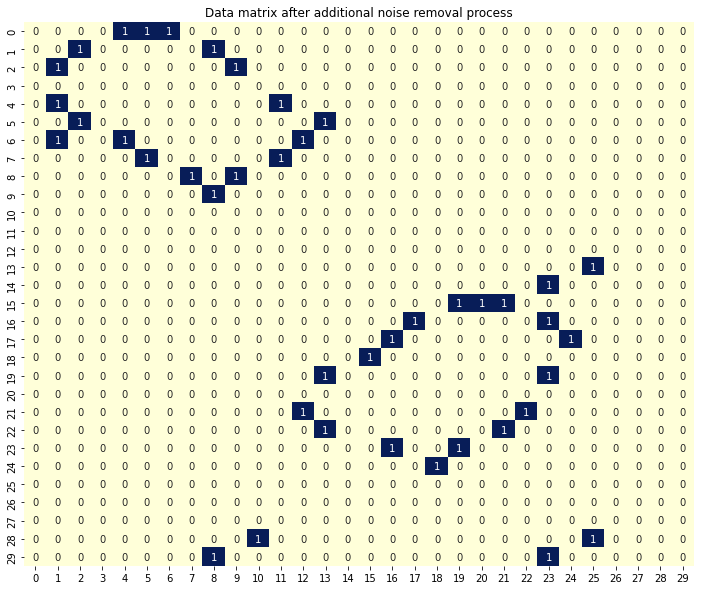

In [50]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Data matrix after additional noise removal process',fontsize = 12)
ax = sns.heatmap(noiseRemoved, square=False,annot=True,cbar=False,cmap="YlGnBu")

### Draw contours for clouds (filling missing out cells). 

With the visualization of the noise thresholded data matrix, we have identified that in the contours of clouds there are some missing cells. That means the countour is not continuous. These missing cells ar in the form of 1 cell gaps and 2 cell gaps. When gaps are more than that it seems like noise, not a cloud contour.
Under this obsevation first we implemented two funtions functions to fill out 1 cell and 2 cell gaps prevailed in the cloud contours. 

##### Filling out 1 cell gaps in cloud contours.

* A 3x3 kernel is carried on the Data matrix and according to the placement of 1s with in the kernel missing cell is repleced by an 1, so that the cloud contours are completed.

* To do this 10 cases have been defined as in the following block of code. 

* If the matching conditions are met, copy of the data matric will be updated.

* After interating thorugh all possible locations for the kernel, following function will output the updated copy of the data matrix.

<font color='yellow'>
Function - kernelFill_1cellgap

Arguments:
>* dataMtraix    - noise filters data matrix.
>* kernalSizeOdd - size of the kernel (odd number like 3,5).

Output:
>* dataMatrixCopy - 30x30 data matrix with filled 1 cell gaps on the cloud contours. 
<font>

In [51]:
def kernelFill_1cellgap(dataMatrix,kernelSizeOdd):
    row, column = dataMatrix.shape
    dataMatrixCopy = dataMatrix.copy()
    
    for i in range(kernelSizeOdd//2, row-kernelSizeOdd//2):
        for j in range(kernelSizeOdd//2, column-kernelSizeOdd//2):
            kernel = dataMatrix[i-kernelSizeOdd//2:i+kernelSizeOdd//2+1,j-kernelSizeOdd//2:j+kernelSizeOdd//2+1]
            
            for k in range (3):
                if  (kernel[k,0] ==1 and kernel[k,2]==1) : 
                    kernelPaste = kernel.copy()
                    kernelPaste[k,1] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[k,1]
                    
                elif (k<1) and (kernel[k,k] ==1 and kernel[k+2,k+2]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[1,1] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[1,1]
                    
                            
                elif (k<2) and (kernel[k,0] ==1 and kernel[k+1,2]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[k+1,1] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[k+1,1]
                    
            
                elif (k<1) and (kernel[k,0] ==1 and kernel[k+2,2]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[k+1,1] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[k+1,1]
                    

                elif (k>1) and (kernel[k,0] ==1 and kernel[k-2,2]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[k-1,1] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[k-1,1]
                    
            
                elif (k>0) and (kernel[k,0] ==1 and kernel[k-1,2]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[k-1,1] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[k-1,1]
                    
                    
                elif (k>0) and (kernel[0,1-k] ==1 and kernel[2,2-k]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[1,k] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[1,k]
                    

                elif (k>0) and (kernel[0,2-k] ==1 and kernel[2,1-k]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[1,k] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[1,k]
                    
                
                elif (k<1) and (kernel[k,k+2] ==1 and kernel[k+2,k]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[1,1] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[1,1]
                    
                    
                elif (kernel[0,k] ==1 and kernel[2,k]==1) :
                    kernelPaste = kernel.copy()
                    kernelPaste[1,k] = 1
                    dataMatrixCopy[i-kernelSizeOdd//2+1,j-kernelSizeOdd//2+1] = kernelPaste[1,k]


    return dataMatrixCopy

In [52]:
contoured_1cellgap = kernelFill_1cellgap(noiseRemoved, 3)

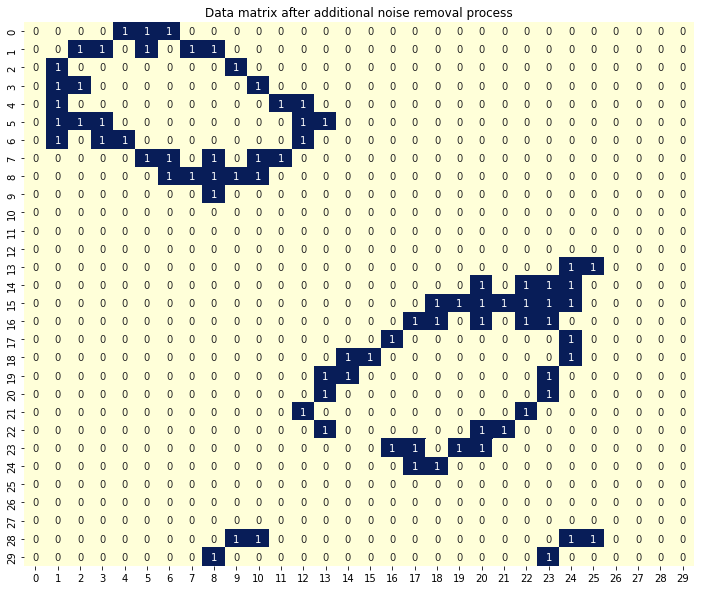

In [53]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Data matrix after additional noise removal process',fontsize = 12)
ax = sns.heatmap(contoured_1cellgap, square=False,annot=True,cbar=False,cmap="YlGnBu")

##### Filling out 2 cell gaps in cloud contours.

* A 4x4 kernel is carried on the Data matrix and according to the placement of 1s with in the kernel two of the missing cells are repleced by 2 1s, so that the cloud contours are completed.

* To do this 10 cases have been defined as in the following block of code. 

* If the matching conditions are met, copy of the data matric will be updated.

* After interating thorugh all possible locations for the kernel, following function will output the updated copy of the data matrix.

<font color='yellow'>
Function - kernelFill_2cellgap

Arguments:
>* dataMtraix    - noise filters data matrix.
>* kernalSizeOdd - size of the kernel (odd number like 3,5).

Output:
>* dataMatrixCopy - 30x30 data matrix with filled 2 cell gaps on the cloud contours. 
<font>

In [54]:
def kernelFill_2cellgap(dataMatrix,kernelSizeEven):
    row, column = dataMatrix.shape
    dataMatrixCopy = dataMatrix.copy()
    
    for i in range(row-kernelSizeEven):
        for j in range(column-kernelSizeEven):
            kernel = dataMatrix[i:i+kernelSizeEven,j:j+kernelSizeEven]

            for k in range (4):
              if  (kernel[k,0] ==1 and kernel[k,3]==1) : 
                kernelPaste = kernel.copy()
                kernelPaste[k,1:3] = 1 
                
                dataMatrixCopy[i+k,j+1:j+3] = kernelPaste[k,1:3]

              elif (k<3) and (kernel[k,0] ==1 and kernel[k+1,3]==1) :
                kernelPaste = kernel.copy()
                kernelPaste[k,1] = 1
                kernelPaste[k+1,2] = 1
                
                dataMatrixCopy[i+k,j] = kernelPaste[k,1]
                dataMatrixCopy[i+k+1,j+2] = kernelPaste[k+1,2]

              elif (k<2) and (kernel[k,0] ==1 and kernel[k+2,3]==1) :
                kernelPaste = kernel.copy()
                kernelPaste[k+1,1] = 1
                kernelPaste[k+2,2] = 1
                
                dataMatrixCopy[i+k+1,j+1] = kernelPaste[k+1,1]
                dataMatrixCopy[i+k+2,j+2] = kernelPaste[k+2,2]

              elif (k<1) and (kernel[k,0] ==1 and kernel[k+3,3]==1) :
                kernelPaste = kernel.copy()
                kernelPaste[k+1,1] = 1
                kernelPaste[k+2,2] =  1 
                
                dataMatrixCopy[i+k+1,j+1] = kernelPaste[k+1,1]
                dataMatrixCopy[i+k+2,j+2] = kernelPaste[k+2,2]

          
    return dataMatrixCopy

In [55]:
contoured_2cellgap = kernelFill_2cellgap(contoured_1cellgap, 4)

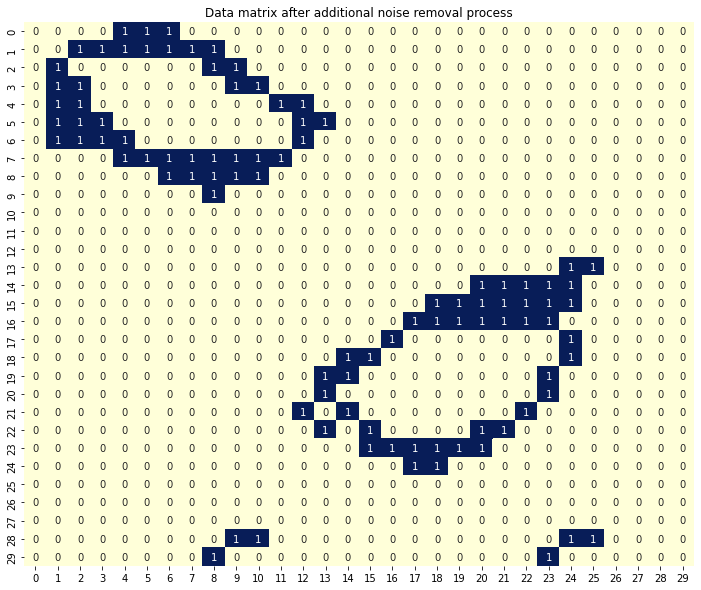

In [56]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Data matrix after additional noise removal process',fontsize = 12)
ax = sns.heatmap(contoured_2cellgap, square=False,annot=True,cbar=False,cmap="YlGnBu")

### Identifying regions for detected clouds.

* After completing the contours, floodfill algorythm is used to fill out the cells insode the cloud contours.

* Then more noise removal steps (noise thresholding) are performed to remove noise with higher thresholds.

* if we used higher thresholds before region identification through floodfill, it would distort the shapes og the contour.

* After identifying regions, higher thresholds can be used for noise thresholding as even in the edges of the detected clouds sum of the kernel value will be higher. So it wont distort the shpe of the cloud and by this step we can reduce the noise in a more granular way.

* Then finally, detected objects are inserted on to the data matrix.

In [57]:

floodFill=cv.floodFill(contoured_2cellgap, None, seedPoint=(0,0), newVal=10)[1]
floodFill = floodFill.get().reshape(echos, bins)
floodFill_replaced = np.where(floodFill==10,0,1)


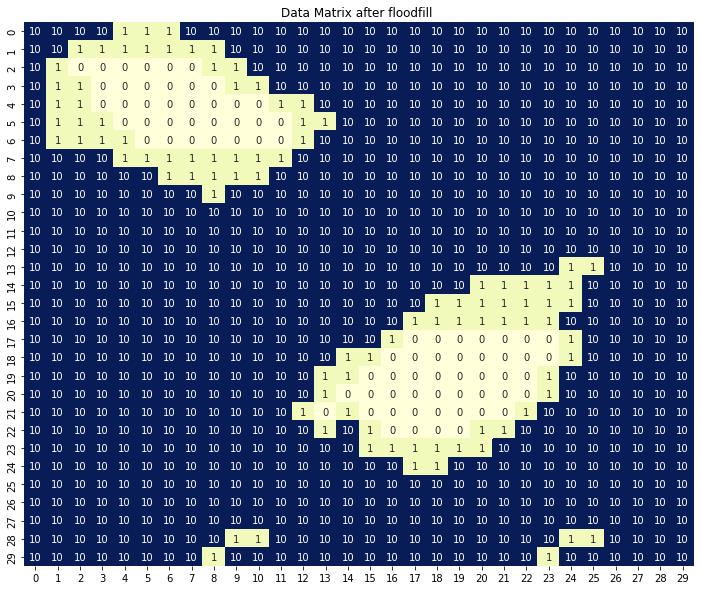

In [58]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Data Matrix after floodfill ',fontsize = 12)
ax = sns.heatmap(floodFill, square=False,annot=True,cbar=False,cmap="YlGnBu")

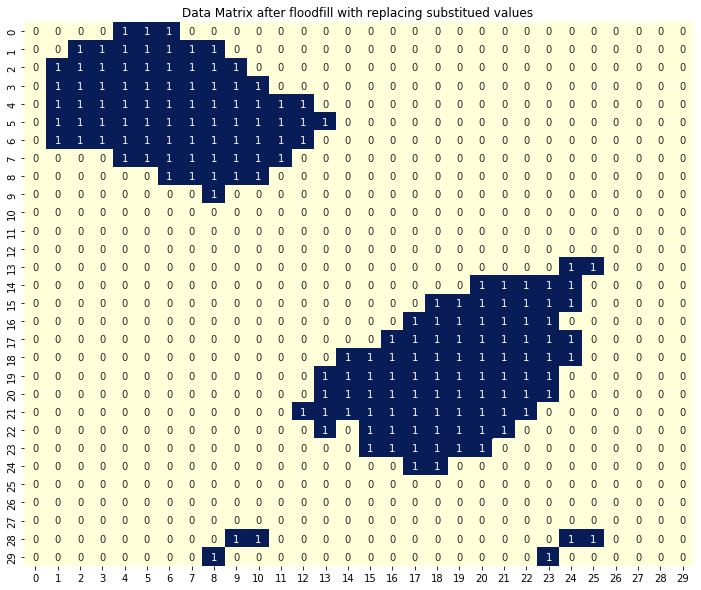

In [59]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Data Matrix after floodfill with replacing substitued values ',fontsize = 12)
ax = sns.heatmap(floodFill_replaced, square=False,annot=True,cbar=False,cmap="YlGnBu")

More noise threshoulding

In [60]:
noiseThresholdingFinal = noiseRemoval(floodFill_replaced, 4, 3).astype(np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


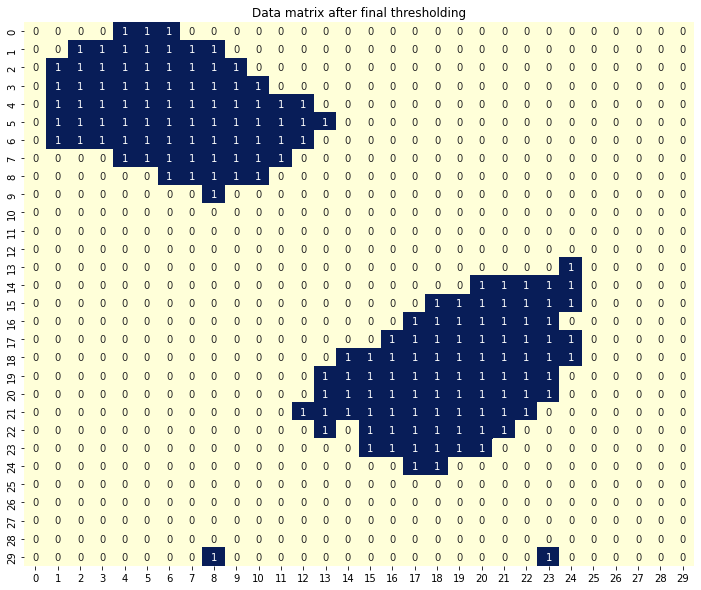

In [61]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Data matrix after final thresholding',fontsize = 12)
ax = sns.heatmap(noiseThresholdingFinal, square=False,annot=True,cbar=False,cmap="YlGnBu")

Padded noise thresholding to remove edge noise.

In [62]:
edgeNoiseRemoved = noiseRemovalPadded(noiseThresholdingFinal, 2,3)

edgeNoiseRemoved = np.delete(edgeNoiseRemoved, 0, 0)
print(noiseRemoved.shape)
edgeNoiseRemoved = np.delete(edgeNoiseRemoved, -1, 0)
print(noiseRemoved.shape)
edgeNoiseRemoved = np.delete(edgeNoiseRemoved, 0, -1)
print(noiseRemoved.shape)
edgeNoiseRemoved = np.delete(edgeNoiseRemoved, -1, -1)
print(noiseRemoved.shape)

(30, 30)
(30, 30)
(30, 30)
(30, 30)


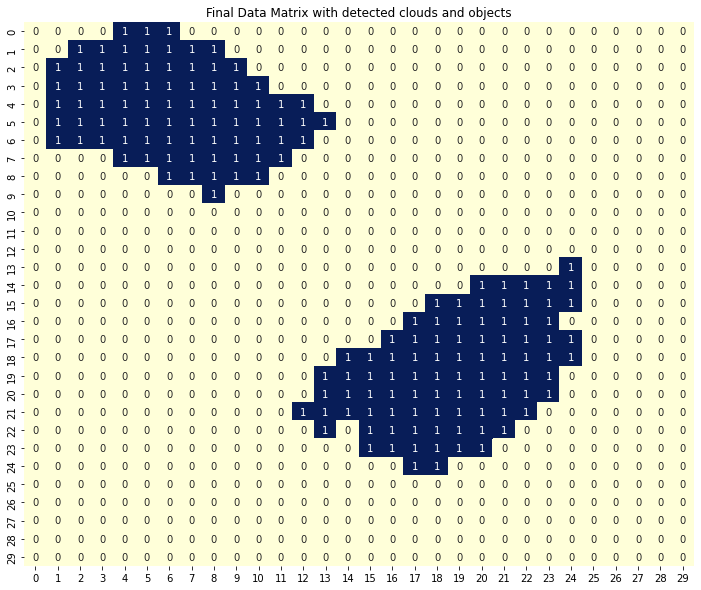

In [63]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Final Data Matrix with detected clouds and objects',fontsize = 12)
ax = sns.heatmap(edgeNoiseRemoved, square=False,annot=True,cbar=False,cmap="YlGnBu")

Inserting detected objects on to the plot.

In [64]:
for i in objectsDetected:
    edgeNoiseRemoved[:,i] = 0.5*1

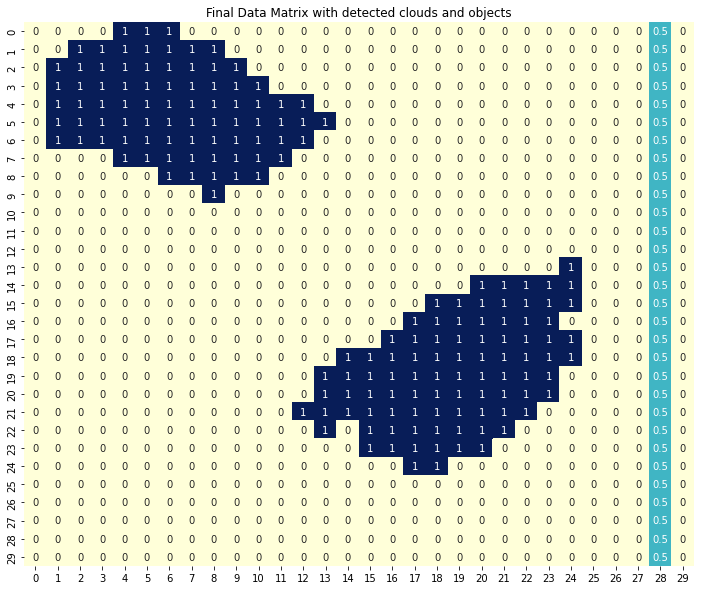

In [65]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Final Data Matrix with detected clouds and objects',fontsize = 12)
ax = sns.heatmap(edgeNoiseRemoved, square=False,annot=True,cbar=False,cmap="YlGnBu")

# Range and the azimuth angle calculation for detected .

#### Display range of the objects:

##### Range calculations:
  
>>> $\Delta R = \frac{c}{2 \times \ Sampling\ Frequency} = 2778m$ 

Here $\Delta R$ denotes the distance covered by a range slot.

So distance/range can be calculated by,

>>> $Range = \Delta R \times range\ slot\ number$

##### Azimuth angle  calculations:

Azimuth angle can be calculated for the detected objects using floowing equation assuming that the initial azimuth angle is zero.

>>> $Azimuth\ angle = [{n + \frac{(m-n)}{2}}] \times \frac{𝑅𝑎𝑑𝑎𝑟 𝑅𝑜𝑡𝑎𝑡𝑖𝑜𝑛 𝑆𝑝𝑒𝑒𝑑 (𝑑𝑒𝑔/𝑠𝑒𝑐)}{𝑃𝑢𝑙𝑠𝑒 𝑅𝑒𝑝𝑖𝑡𝑖𝑜𝑛 𝐹𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦}$

<font color='yellow'>
Function - consecutiveRanges

Arguments:
>* a    - 1D array of intergers.
>* n - length of a.

Output:
>* list - array in the follwing form. 

>>if the input is,

>>>>> [1, 2, 3, 56, 89, 6, 7, 8]

>>the output is,

>>>>> [[1, 3], 56, 89, [6, 7]]

<font>


This function outputs the ranges for the objects identified in the objectsDetected array. 
If a target is detected between pulses n through m (m>n). [m - n] is outputed.

In [68]:
def consecutiveRanges(a, n):
    length = 1
    list = []
    if (n == 0):
        return list
    for i in range (1, n + 1):
        if (i == n or a[i] - a[i - 1] != 1):
            if (length == 1):
                pass
                list.append([a[i - length]])
            else:
                temp = [a[i - length],a[i - 1]]
                list.append(temp)
            length = 1
        else:
            length += 1
    return list

In [69]:
azimuthAngle_object = []
range_object = []

consecutive_ranges = consecutiveRanges(objectsDetected, len(objectsDetected))

if len(objectsDetected)==0:
    print("No objects detected")
else:
    for x in consecutive_ranges:
        #calculating azimuth angle of the object detected
        if len(x)!=1:
            azimuth = ((x[0]+1)+(x[1]-x[0])/2)*((rotationSpeed*360/60)/f_pulseRepetiion)
        else:
            azimuth = ((x[0]+1)+1/2)*((rotationSpeed*360/60)/f_pulseRepetiion)
        
        azimuthAngle_object.append(azimuth)
                   
        #calculating range of the object detected
        Range = (C/(2*f_sampling))*(x[0]+1)*1e-3
        range_object.append(Range)
        
# print(azimuthAngle_object)
# print(range_object)

for i in range(len(objectsDetected)):
    print(f'Location for object {i+1} : ({range_object[i]}km, {azimuthAngle_object[i]}rad)')

Location for object 1 : (80.55555555555556km, 1.18rad)
